In [16]:
import numpy as np
from matplotlib import pyplot as plt


In [17]:
def square(patterns):
    x = np.sin(patterns)
    return np.where(x>=0,1,-1)

def generate_data(is_sin):
    training_patterns = np.arange(0,2*np.pi,0.1)
    
    test_patterns = np.arange(0,2*np.pi,0.05)
    

    if is_sin:
        training_targets = np.sin(2*training_patterns)
        test_targets = np.sin(2*test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets , test_patterns, test_targets
    
    else:
        training_targets = square(training_patterns)
        test_targets = square(test_patterns)
        i = np.arange(training_patterns.shape[0])
        np.random.shuffle(i)
        training_patterns=training_patterns[i]
        training_targets=training_targets[i]

        i = np.arange(test_patterns.shape[0])
        np.random.shuffle(i)
        test_patterns=test_patterns[i]
        test_targets=test_targets[i]
        return training_patterns, training_targets, test_patterns, test_targets


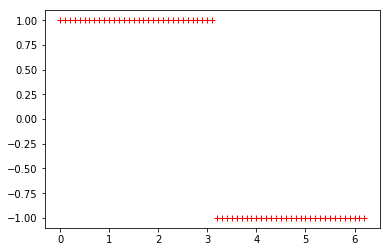

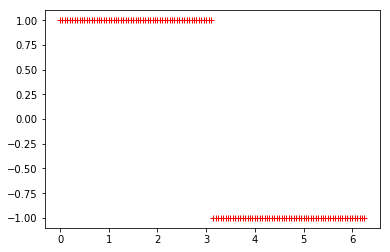

In [18]:
training_patterns, training_targets, test_patterns, test_targets = generate_data(0)
plt.plot(training_patterns,training_targets, 'r+')
plt.figure()
plt.plot(test_patterns,test_targets,'r+')

In [56]:
def evenly_spaced_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = i*2*np.pi/n
    return mu_s

def random_rbf(n):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = (2*np.random.random_sample()*np.pi)
    
    return mu_s

def competetive_rbf(n,x_s,iterations,eta,n_winners):
    mu_s = np.zeros((n,1))
    for i in range(n):
        mu_s[i] = 2*np.pi*np.random.random_sample()
    random_mu_s = mu_s
    #plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    plt.scatter(mu_s,np.sin(2*mu_s), c='b', label="Before")
    #print(mu_s)
    #mu_s = mu_s/np.linalg.norm(mu_s)
    #mu_s = mu_s*2*np.pi
    #print(iterations)
    for i in range(iterations):
        train_vec = x_s[np.random.randint(0,x_s.shape[0])]
        distances = np.empty((0,0))
        for mu in mu_s:
            distances = np.append(distances,(np.linalg.norm(train_vec-mu)))
        
        ind = np.argpartition(distances, -n_winners)[-n_winners:]
        
        #print(abs(train_vec-closest_mu))
        #print(i)
        for k in ind:
            mu_s[k] = mu_s[k]+eta*(train_vec-mu_s[k])
        #mu_s = mu_s/np.linalg.norm(mu_s)
        #mu_s = mu_s*2*np.pi
    plt.figure()
    
    plt.scatter(mu_s,np.sin(2*mu_s), c='r', label="After")
    return mu_s, random_mu_s


In [57]:
def calculate_mse(f_hat,f):
    return np.mean((f_hat-f)**2)

def calculate_NMAE(f_hat,f):
    return np.mean(np.abs(f_hat-f))

def gaussian(x, mu, sigma):
    #print(x.shape)
    #print(mu.shape)
    #print(np.exp(-(x-mu)**2/(2*sigma**2)).shape)
    return np.exp(-(x-mu)**2/(2*sigma**2))

    
def get_phi_batch(x_s, mu_s,sigma):
    phi_s = np.zeros((x_s.shape[0],mu_s.shape[0]))
    for i, mu in enumerate(mu_s):
        for j, x in enumerate(x_s):
            phi_s[j,i]=gaussian(mu,x,sigma)
    return phi_s

def get_phi_seq(x_s,mu_s, sigma):
    #print(x_s.shape)
    phi_s = np.zeros((mu_s.shape[1],1))
    #print(phi_s.shape)
    for i, mu in enumerate(mu_s.T):
        #print(i)
        phi_s=gaussian(mu,x_s,sigma)
    return phi_s

def train_network_batch(x_s,f,mu_s,sigma):

    phi_s = get_phi_batch(x_s,mu_s,sigma)
    #print(phi_s.shape)
    #print(phi_s)
    #dim phi_s(Nxn) dim weight(nx1)
    
    w = np.matmul(np.matmul(phi_s.T,f),np.linalg.inv(np.matmul(phi_s.T,phi_s)))
    f_hat = np.sum(np.multiply(phi_s,w),axis=1)
    mse = calculate_mse(f_hat,f)
    return w, mse

def train_network_delta_rule(x_s,f,mu_s,sigma,eta, epochs):
    """
    w=np.random.randn(mu_s.shape[0],1)
    
    for epoch in range(epochs):

        f_hat = np.zeros(f.shape[0])
        for k,x in enumerate(x_s):
            phi_s_x_k = np.zeros((mu_s.shape[0],1))
            for n,mu in enumerate(mu_s):
                phi_s_x_k[n] = gaussian(x,mu,sigma)
            #print(phi_s_x_k.shape)
            #print(w.shape)
            f_hat[k] = np.dot(phi_s_x_k.T,w)
            e = (f[k] - f_hat[k])**2
            delta_w = eta*e*phi_s_x_k
            w = w + delta_w
    """
    learning_error_list= np.zeros(epochs)
    W=np.random.randn(mu_s.shape[0],1)
    
    for i in range(epochs):
        e_list=[]
        x = np.zeros(1)
        for k in range(np.shape(x_s)[0]):
            x[0] = x_s[k]
            #print(mu_s.shape)
            #print(x.shape)
            phi = get_phi_seq(x,mu_s,sigma)
            phi = phi.reshape(1,-1)
            e=f[k]-phi.dot(W)
            error=np.float(0.5*(e**2))
            e_list.append(error)
            W=W+eta*e*phi.reshape(mu_s.shape[0],1)

        learning_error=np.mean(e_list)
        learning_error_list[i] = learning_error
    
    #return w,calculate_mse(f,f_hat)
    return W, np.mean(learning_error_list)
    
    
    return w, np.mean(tmp)
def predict(x_s,mu_s,sigma,w):
    phi_s = get_phi(x_s,mu_s,sigma)
    
    w = w.reshape((w.shape[0],1))
    f_hat = np.sum(np.dot(phi_s,w),axis=1)
    return f_hat

def predict_seq(x_s,mu_s,sigma,w):
    f_hats = np.zeros(x_s.shape[0])
    x = np.zeros(1)
    for k in range(np.shape(x_s)[0]):
        x[0] = x_s[k]
        phi_s = get_phi_seq(x,mu_s,sigma)
    
        w = w.reshape((w.shape[0],1))
        f_hat = np.sum(np.dot(phi_s,w))
        f_hats[k] = f_hat
    return f_hats

[[0.        ]
 [0.62831853]
 [1.25663706]
 [1.88495559]
 [2.51327412]
 [3.14159265]
 [3.76991118]
 [4.39822972]
 [5.02654825]
 [5.65486678]]
[[5.13643149]
 [0.42708945]
 [2.96874078]
 [3.93471515]
 [2.25133453]
 [5.10875387]
 [4.88656001]
 [5.66846167]
 [2.28319815]
 [0.38429096]]
(63,)
MSE seq: 0.29565233172709576
MSE seq test:  0.33680478068141084
(63,)
MSE: 0.013390994760166105


ValueError: operands could not be broadcast together with shapes (10,) (126,) 

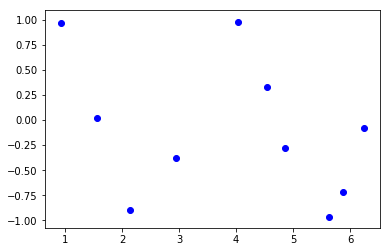

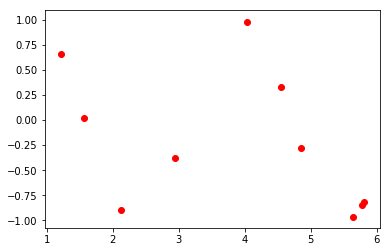

In [59]:
noise = True

sigma = 1
num_of_rbf = 10
eta = 1e-2
epochs = 10
training_patterns, training_targets, test_patterns, test_targets = generate_data(1)
if noise:
    noise=np.random.randn(training_patterns.shape[0])*0.1
    noise_test=np.random.randn(test_patterns.shape[0])*0.1
    training_patterns = training_patterns+noise
    test_patterns = test_patterns+noise_test

mu_s = evenly_spaced_rbf(num_of_rbf)
print(mu_s)
mu_s = random_rbf(num_of_rbf)
#print(mu_s)

print(mu_s)
#mu_s = unevenly_spaced_rbf(num_of_rbf)
#print(mu_s)
print(training_patterns.shape)
#w,mse = train_network_batch(training_patterns, training_targets,mu_s,sigma)
#print("MSE:", mse)
#f_hat = predict(test_patterns,mu_s,sigma,w)
#mse_test = calculate_mse(f_hat,test_targets)
#print("MSE test:",mse_test)
#plt.figure()
#plt.plot(test_patterns,f_hat,'+')
mu_s, random_mu_s = competetive_rbf(num_of_rbf,training_patterns,20,eta,1)

w, mse = train_network_delta_rule(training_patterns, training_targets,mu_s,sigma,eta,epochs)
print("MSE seq:", mse)
f_hat = predict_seq(test_patterns,mu_s,sigma,w)
mse_test = calculate_mse(f_hat,test_targets)
print("MSE seq test: ",mse_test)
mse_test = calculate_mse(f_hat,test_targets)
#mu_s = evenly_spaced_rbf(num_of_rbf)
#print(mu_s)
#print(mu_s)

#mu_s = competetive_rbf(num_of_rbf,training_patterns,100,eta)
#print(mu_s)
#mu_s = unevenly_spaced_rbf(num_of_rbf)
#print(mu_s)
print(training_patterns.shape)
w,mse = train_network_batch(training_patterns, training_targets,mu_s,sigma)
print("MSE:", mse)
f_hat = predict(test_patterns,mu_s,sigma,w)
mse_test = calculate_mse(f_hat,test_targets)
print("MSE test:",mse_test)
#plt.figure()
plt.plot(test_patterns,f_hat,'+')

w, mse = train_network_delta_rule(training_patterns, training_targets,mu_s,sigma,eta,epochs)
print("MSE seq:", mse)